In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Dense, LSTM, GRU, Flatten, GlobalMaxPooling1D
from keras.optimizers import Adam, SGD


from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark") 

np.random.seed(42)
tf.random.set_seed(42)

2024-05-10 22:09:48.797791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### RNN's (LSTM's) for Time-series forecast: Airline Passenger data 
---------
We will build a Recurrent Neural Network (LSTM) to predict airline passenger data using 3 different supervised methods:

1. Supervised one step forecast 
2. Incremental, multi-step forecast
3. Multi-output, multi-step forecasting

Many different configurations to try for a given problem: 

1. Basic: only keep h(T) from RNN
2. Keep all h(t)'s, then Global Max Pooling
3. Stack multiple LSTMs

In [2]:
# get data 

!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-05-10 18:34:17--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: 'airline_passengers.csv'

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-05-10 18:34:18 (8.44 MB/s) - 'airline_passengers.csv' saved [2036/2036]



In [2]:
df = pd.read_csv('airline_passengers.csv', index_col=0, parse_dates = True)

df['LogPassengers']=np.log(df['Passengers'])

# differenced Log passegers 

df['DiffLogPassengers'] = df['LogPassengers'].diff()

df.head()


,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


In [3]:
N_test = 12
train, test = df.iloc[:-N_test], df.iloc[-N_test:]

# booleand indexing 

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [4]:
# Prepare a supervised data set using T last vals to predict the next 

series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10 
X = []
Y = []

for t in range(len(series)-T):

    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)

print(f'Shape of X: {X.shape}', f'Shape of Y:{Y.shape}')

Shape of X: (133, 10, 1) Shape of Y:(133,)


In [5]:
# Test and train split for the supervised data set X and Y 

X_train, y_train = X[:-N_test], Y[:-N_test]
X_test, y_test = X[-N_test:], Y[-N_test:]

In [6]:
# RNN (LSTM)

i = Input(shape = (T,1))
x = LSTM(24)(i) # activation is tanh by default 
x = Dense(1)(x)

model = Model(i,x)

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# compile and fit 

model.compile(loss = 'mse', optimizer = 'adam')

res = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test))


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0120 - val_loss: 0.0108
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - val_loss: 0.0105
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112 - val_loss: 0.0100
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110 - val_loss: 0.0097
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0103 - val_loss: 0.0090
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0100 - val_loss: 0.0087
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0097 - val_lo

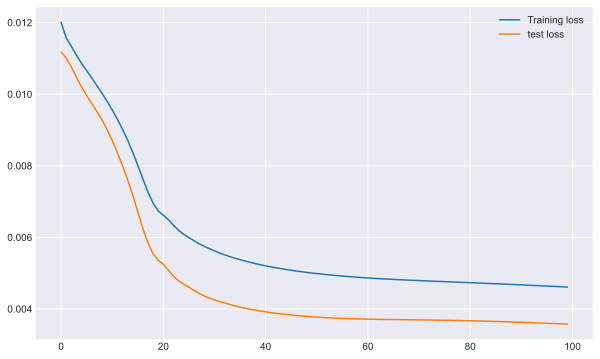

In [9]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(res.history['loss'], label = 'Training loss')
axes.plot(res.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

In [10]:
# First T+1 values are not predictable since we differenced the Log Passenger data 

train_idx[:T+1] = False

In [11]:
# get training and test predictions and store them

pred_train = model.predict(X_train).flatten()
pred_test = model.predict(X_test).flatten()

df.loc[train_idx, 'RNN_train_p'] = pred_train
df.loc[test_idx, 'RNN_test_p'] = pred_test

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


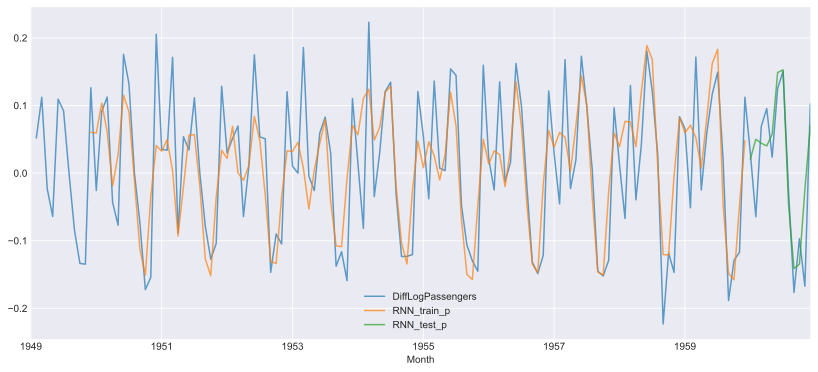

In [12]:
# Plot predictions vs data 

fig, axes = plt.subplots(figsize = (14,6))

p_cols = df.columns.to_list()

df[p_cols[-3:]].plot(ax = axes, alpha = 0.7)

axes.grid()

In [13]:
# Compute the un-differenced predictions 

df['LogPassengers_Shifted'] = df['LogPassengers'].shift(1)

prev = df['LogPassengers_Shifted']

# 1 - step forecast, recall that we modified train_idx setting first T+1 vals to False

df.loc[train_idx, '1s_train_pred'] = prev[train_idx] + pred_train

df.loc[test_idx, '1s_test_pred'] = prev[test_idx] + pred_test

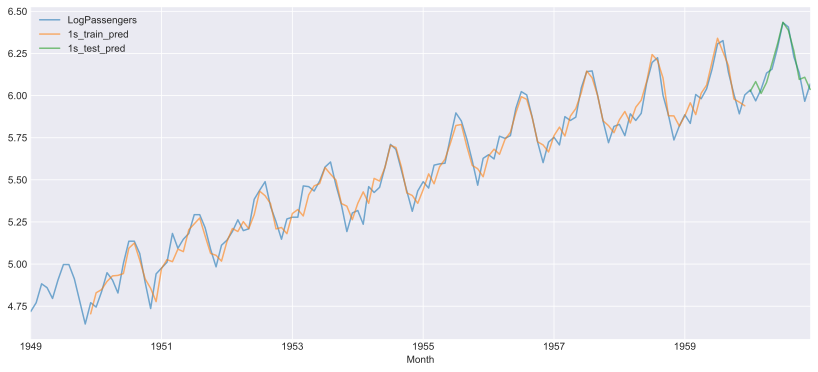

In [14]:
# Plot actual predictions 

fig, axes = plt.subplots(figsize = (14,6))

cols = ['LogPassengers', '1s_train_pred', '1s_test_pred']

df[cols].plot(ax= axes, alpha = 0.6)

axes.grid()

In [15]:
# multi-step incremental forecast 

ms_preds = []

# first test input 

last_x = X_test[0]

while len(ms_preds)< N_test:
    
    pred = model.predict(last_x.reshape(1,-1, 1))[0]

    # update the predictions list 

    ms_preds.append(pred)

    # make the new input 

    last_x = np.roll(last_x, -1)
    last_x[-1] = pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


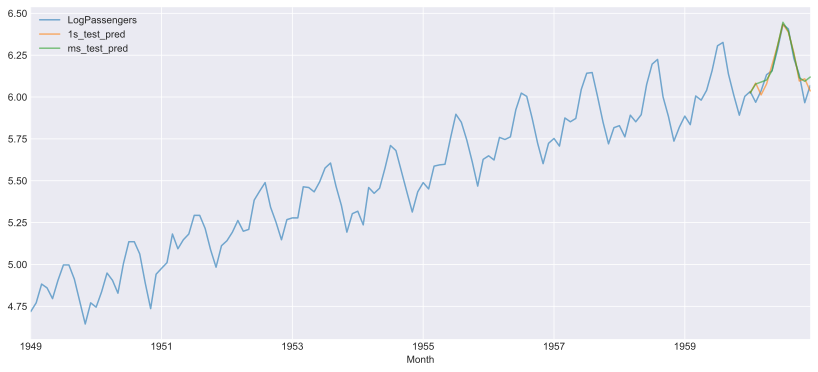

In [16]:
# save multi-step forecast to df and plot with respect to 1-step test forecasts 

last_train = train.iloc[-1]['LogPassengers'] # Last known train value 

df.loc[test_idx, 'ms_test_pred'] = last_train + np.cumsum(ms_preds)

fig, axes = plt.subplots(figsize = (14,6))

df[['LogPassengers', '1s_test_pred', 'ms_test_pred']].plot(ax = axes, alpha = 0.6)

axes.grid()

In [17]:
# Prepare multi-output supervised dataset 

Tx = T
Ty = N_test

X = []
Y = []

for t in range(len(series)- Tx- Ty + 1):

    x = series[t:t + Tx]
    X.append(x)

    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)


X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)

print(f'X shape: {X.shape}', f'Y shape: {Y.shape}')

X shape: (122, 10, 1) Y shape: (122, 12)


In [18]:
# train- test split 

X_train_m, y_train_m  = X[:-1], Y[:-1]

X_test_m, y_test_m = X[-1:], Y[-1:] # last entry in the X and Y will be the test set

In [19]:
# Multi-output LSTM 

i = Input(shape = (Tx,1))
x = LSTM(24, return_sequences=True)(i) # activation is tanh by default 
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)

mo_model = Model(i,x)

In [20]:
mo_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 24)         │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 24)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,796 (10.92 KB)

 Trainable params: 2,796 (10.92 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
check_point = ModelCheckpoint('best_model.keras', monitor = 'val_loss', save_best_only=True)

mo_model.compile(loss = 'mse', optimizer = 'adam')

mo_res = mo_model.fit(X_train_m, y_train_m, epochs = 200, callbacks=[check_point], validation_data = (X_test_m, y_test_m))

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0114 - val_loss: 0.0108
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0111 - val_loss: 0.0109
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0109 - val_lo

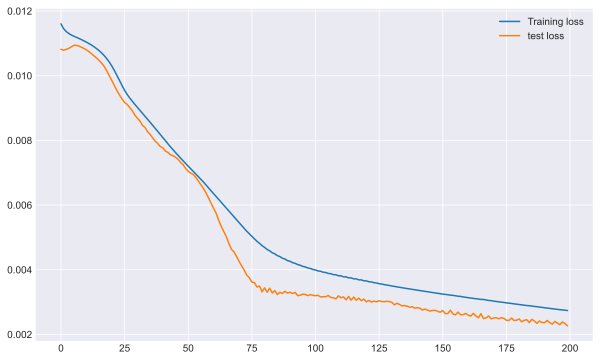

In [22]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(mo_res.history['loss'], label = 'Training loss')
axes.plot(mo_res.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

Test error is lower than training, which is a bit unusual as it is not increasing as well to indicate overfitting. 

In [23]:
# Load best model 

best_model = tf.keras.models.load_model('best_model.keras')

In [25]:
# get train and test predictions 

pred_train = best_model.predict(X_train_m)

pred_test = best_model.predict(X_test_m)

pred_train.shape, pred_test.shape

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/stepWARNING:tensorflow:5 out of the last 23 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f8631b60f70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


((121, 12), (1, 12))

In [26]:
# indexing predictions, for the train set we will treat them as one step prediction and simply grab the first column 
# we can do so as we use 1,...10, to predict 11,...,22 and then use 2,...,11 to predict, 12,...,23 rd vals and so on
# so the 0th column of each row corresponds to one step prediction for the training set 
# this is a valid approach because the predictions closer to the current time would be expected to be more accurate 

pred_train = pred_train[:,0]

pred_test = pred_test[0]

In [27]:
# save multi-output forecasts 

df.loc[test_idx, 'mo_test_pred'] = last_train + np.cumsum(pred_test)

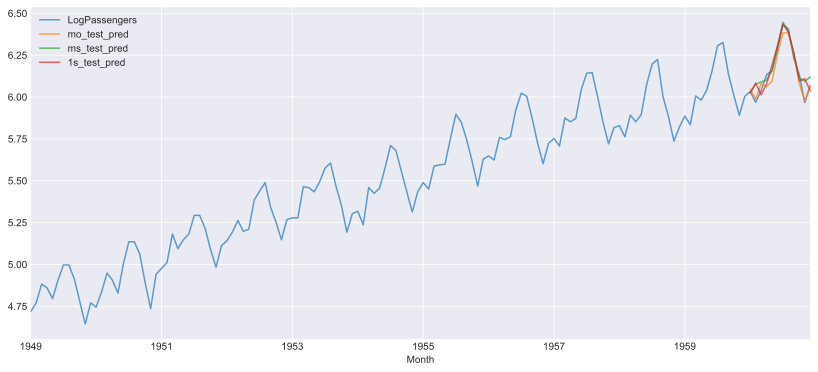

In [28]:
# And plot 

fig, axes = plt.subplots(figsize = (14,6))
cols = ['LogPassengers', 'mo_test_pred', 'ms_test_pred', '1s_test_pred']

df[cols].plot(ax = axes, alpha = 0.7)

axes.grid()

In [29]:
# lets compare their MAPEs

test_lpass = df.iloc[-N_test:]['LogPassengers']

mape_ms = mean_absolute_percentage_error(test_lpass, df.loc[test_idx, 'ms_test_pred'])
mape_mo = mean_absolute_percentage_error(test_lpass, df.loc[test_idx, 'mo_test_pred'])

print(f'Multi-step method MAPE: {mape_ms:.3f}\n',f"Multi-output method MAPE: {mape_mo:.3f}")

Multi-step method MAPE: 0.006
 Multi-output method MAPE: 0.005


As the plot indicate multi-output model does perform better! 

In [30]:
# Multi-output LSTM-2 with different architecture

i = Input(shape = (Tx,1))
x = LSTM(10, return_sequences=True)(i)
x = LSTM(10, return_sequences=True)(x) # activation is tanh by default 
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)

mo_model2 = Model(i,x)

In [31]:
mo_model2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10, 10)         │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 10)         │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 10)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,452 (5.67 KB)

 Trainable params: 1,452 (5.67 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
check_point2= ModelCheckpoint('best_model2.keras', monitor = 'val_loss', save_best_only=True)

mo_model2.compile(loss = 'mse', optimizer = 'adam')

mo_res2 = mo_model2.fit(X_train_m, y_train_m, epochs = 200, callbacks=[check_point2], validation_data = (X_test_m, y_test_m))

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0112 - val_loss: 0.0110
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0111 - val_loss: 0.0115
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 10/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 11/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0109 - val_loss: 0.0116
Epoch 12/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0109 - val_l

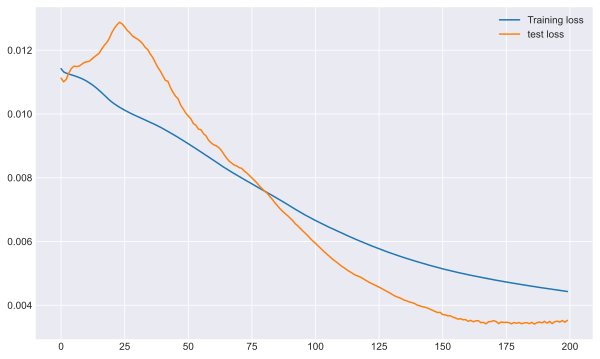

In [33]:
fig, axes = plt.subplots(figsize = (10,6))

axes.plot(mo_res2.history['loss'], label = 'Training loss')
axes.plot(mo_res2.history['val_loss'], label = 'test loss')

axes.grid()
axes.legend()

In [34]:
# Load best model 

best_model2 = tf.keras.models.load_model('best_model2.keras')

In [35]:
# get train and test predictions 

pred_train2 = best_model2.predict(X_train_m)

pred_test2 =  best_model2.predict(X_test_m)

pred_train2.shape, pred_test2.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


((121, 12), (1, 12))

In [36]:
# indexing predictions, for the train set we will treat them as one step prediction and simply grab the first column 
# we can do so as we use 1,...10, to predict 11,...,22 and then use 2,...,11 to predict, 12,...,23 rd vals and so on
# so the 0th column of each row corresponds to one step prediction for the training set 
# this is a valid approach because the predictions closer to the current time would be expected to be more accurate 

pred_train2 = pred_train2[:,0]

pred_test2 = pred_test2[0]

In [37]:
# save multi-output forecasts 

df.loc[test_idx, 'mo_test_pred2'] = last_train + np.cumsum(pred_test2)

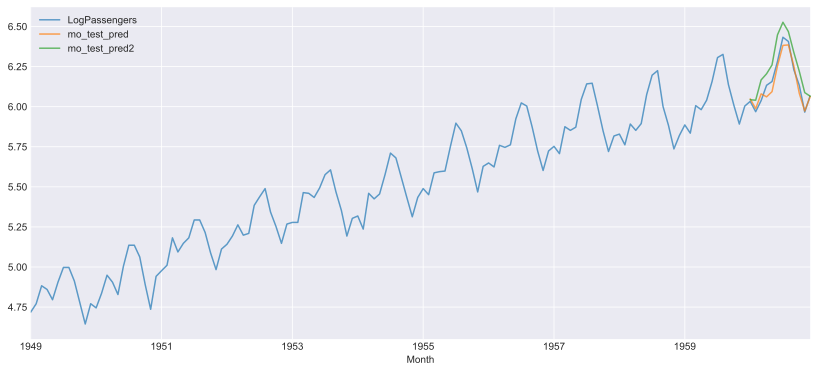

In [38]:
# And plot 

fig, axes = plt.subplots(figsize = (14,6))
cols = ['LogPassengers', 'mo_test_pred', 'mo_test_pred2']

df[cols].plot(ax = axes, alpha = 0.7)

axes.grid()

In [40]:
# lets compare their MAPEs

test_lpass = df.iloc[-N_test:]['LogPassengers']

mape_ms = mean_absolute_percentage_error(test_lpass, df.loc[test_idx, 'ms_test_pred'])
mape_mo = mean_absolute_percentage_error(test_lpass, df.loc[test_idx, 'mo_test_pred'])
mape_mo2 = mean_absolute_percentage_error(test_lpass, df.loc[test_idx, 'mo_test_pred2'])

print(f'Multi-step method MAPE: {mape_ms:.3f}\n',f"Multi-output method MAPE: {mape_mo:.3f}\n", f"Multi-output method 2 MAPE: {mape_mo2:.3f}")

Multi-step method MAPE: 0.006
 Multi-output method MAPE: 0.005
 Multi-output method 2 MAPE: 0.014
